In [1]:
%%capture
!pip install pafy youtube-dl moviepy

In [2]:
!pip install tensorflow


In [4]:
import os
import cv2
import pafy
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt
from moviepy.editor import *
%matplotlib inline
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model


In [6]:
seed_constant =27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

Data Acquisition

In [7]:
%%capture
!wget --no-check-certificate https://www.crcv.ucf.edu/data/UCF50.rar
!unrar X UCF50.rar

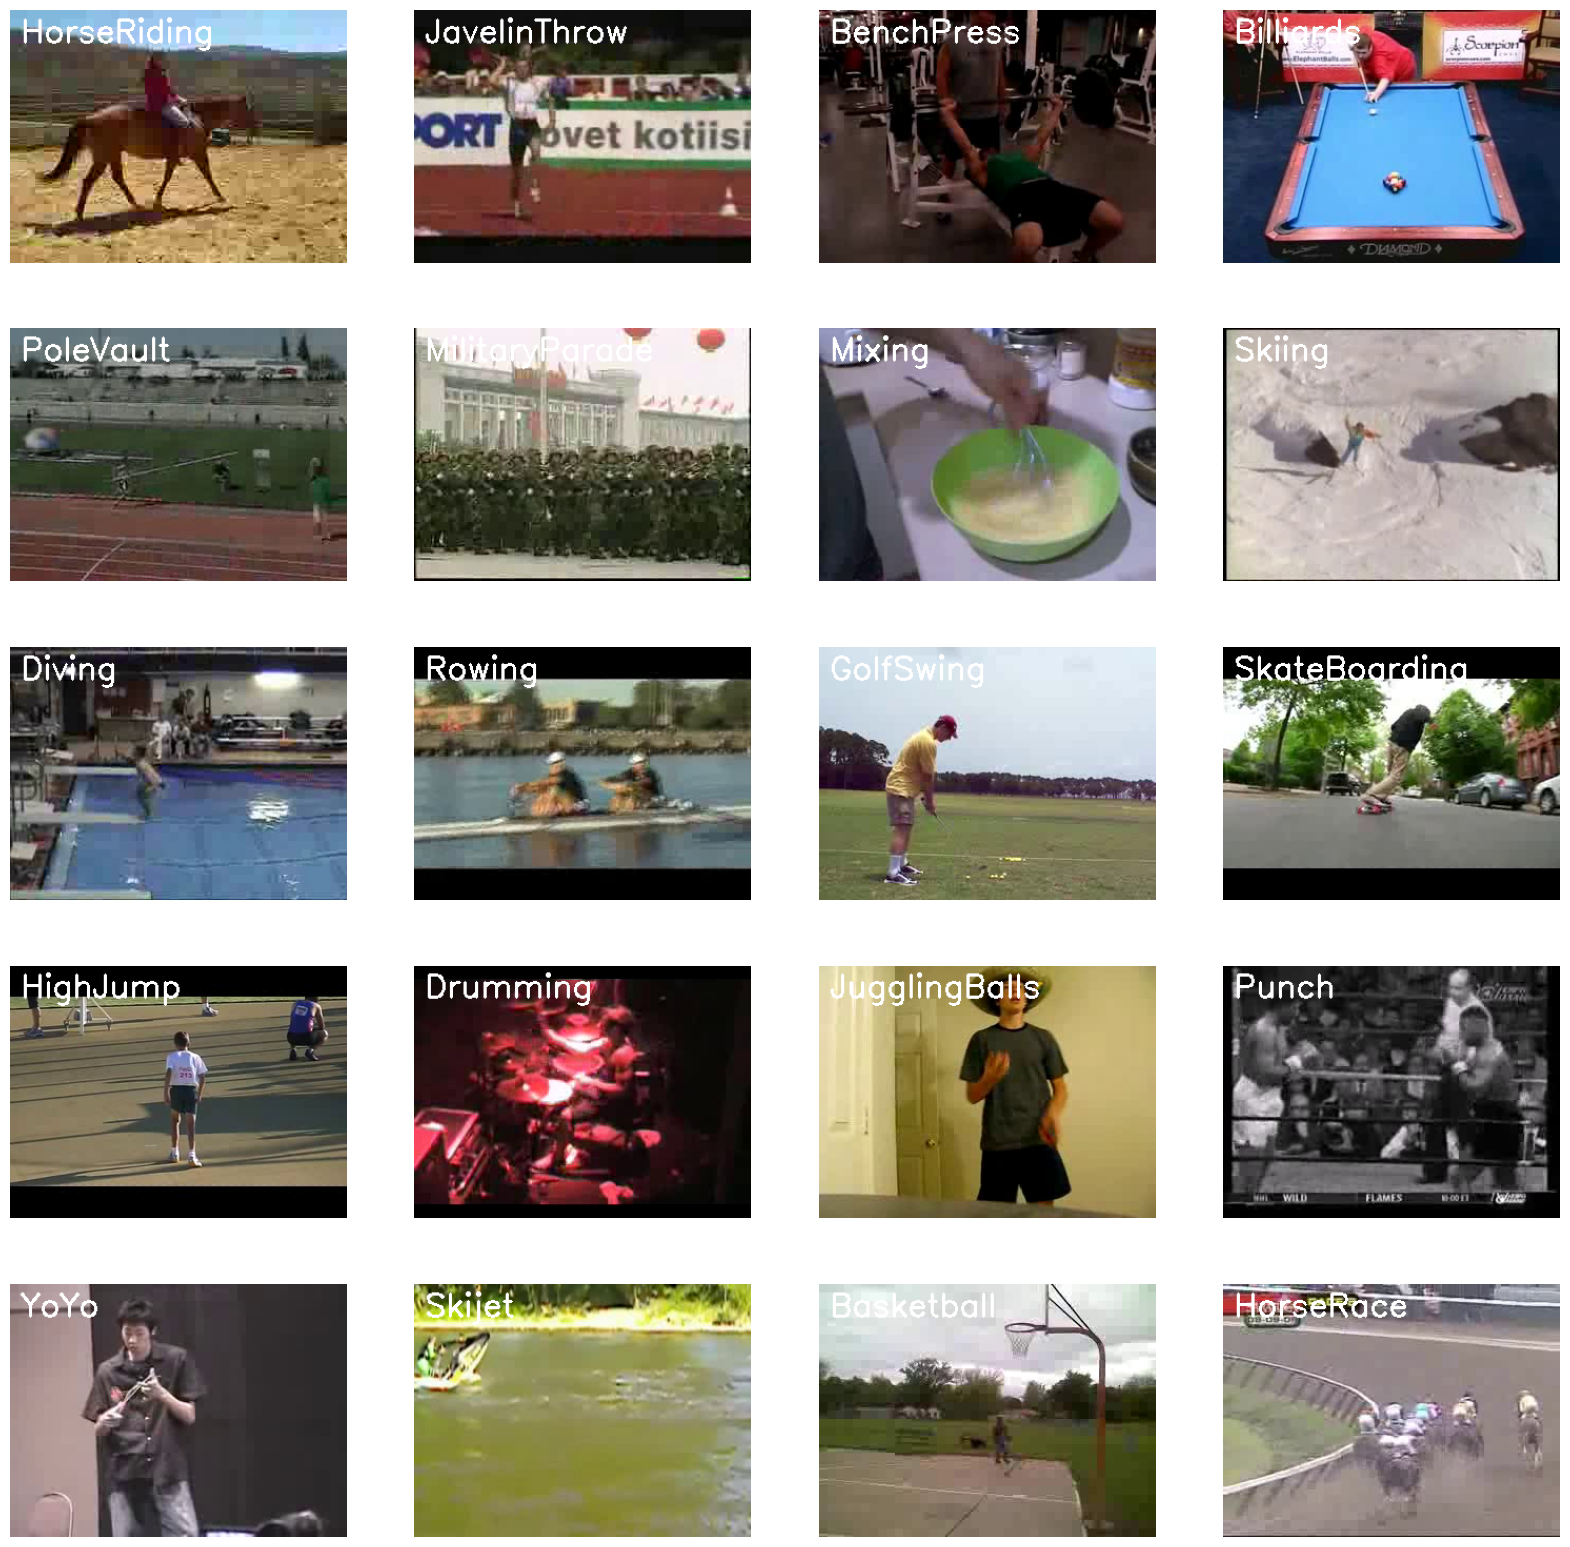

In [9]:
plt.figure(figsize =(20,20))
all_classes_names =os.listdir('UCF50')
random_range=random.sample(range(len(all_classes_names)),20) #picking 20 random categories fro dataset
for counter,random_index in enumerate(random_range,1):
  selected_class_Name= all_classes_names[random_index]
  video_files_names_list= os.listdir(f'UCF50/{selected_class_Name}')
  selected_video_file_name =random.choice(video_files_names_list)
  video_reader = cv2.VideoCapture(f'UCF50/{selected_class_Name}/{selected_video_file_name}')
  _ , bgr_frame = video_reader.read()
  video_reader.release()
  rgb_frame=cv2.cvtColor(bgr_frame,cv2.COLOR_BGR2RGB)
  cv2.putText(rgb_frame,selected_class_Name,(10,30),cv2.FONT_HERSHEY_SIMPLEX,1,(255,255,255),2)
  plt.subplot(5,4,counter);plt.imshow(rgb_frame);plt.axis('off')


Preprocessing

In [13]:
IMAGE_HEIGHT,IMAGE_WIDTH = 64,64
SEQUENCE_LENGTH =20 #no of frames per video
DATASET_DIR ='UCF50'
CLASSES_LIST=['WalkingWithDog','Drumming','Swing','HorseRace','YoYo','Punch','HighJump','Basketball'] #training on 8 classes

In [14]:
def frames_extraction(video_path):
  frames_list=[]
  video_reader=cv2.VideoCapture(video_path)
  video_frames_count =int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT)) #total no of frames in video
  skip_frames_window=max(int(video_frames_count/SEQUENCE_LENGTH),1) #interval at which frames need to be collected to get the sequence length
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter * skip_frames_window) #setting current position
    success, frame =video_reader.read() #reading the frame from video
    if not success:
      break
    resized_frame =cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame =resized_frame/ 255
    frames_list.append(normalized_frame)
  video_reader.release()
  return frames_list



In [15]:
def create_dataset():
  features=[]
  labels=[]
  video_files_paths=[]
  for class_index,class_name in enumerate(CLASSES_LIST):
    print(f'Extracting Data of Class:{class_name}')
    files_list = os.listdir(os.path.join(DATASET_DIR,class_name))
    for file_name in files_list:
      video_file_path = os.path.join(DATASET_DIR,class_name,file_name)
      frames= frames_extraction(video_file_path)
      if len(frames)== SEQUENCE_LENGTH:
        features.append(frames)
        labels.append(class_index)
        video_files_paths.append(video_file_path)
  features= np.asarray(features)
  labels=np.array(labels)
  return features,labels,video_files_paths



In [16]:
features,labels,video_files_paths =create_dataset()


Extracting Data of Class:WalkingWithDog
Extracting Data of Class:Drumming
Extracting Data of Class:Swing
Extracting Data of Class:HorseRace
Extracting Data of Class:YoYo
Extracting Data of Class:Punch
Extracting Data of Class:HighJump
Extracting Data of Class:Basketball


In [17]:
one_hot_encoded_labels= to_categorical(labels)

Split Train and Test Data

In [19]:
features_train,features_test,labels_train, labels_test =train_test_split(features, one_hot_encoded_labels,test_size= 0.25,shuffle = True,random_state= seed_constant)

ConvLSTM Approach -3D input

In [23]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import ConvLSTM2D, MaxPooling3D, TimeDistributed, Dropout, Flatten, Dense
def create_convlstm_model():
  model= Sequential()
  model.add(ConvLSTM2D(filters =4, kernel_size =(3,3),activation ='tanh',data_format='channels_last',recurrent_dropout=0.2,return_sequences =True,input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT , IMAGE_WIDTH,3)))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding ='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=8,kernel_size=(3,3),activation ='tanh', data_format='channels_last',recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=14,kernel_size=(3,3),activation ='tanh', data_format='channels_last',recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding ='same',data_format='channels_last'))
  model.add(TimeDistributed(Dropout(0.2)))
  model.add(ConvLSTM2D(filters=16,kernel_size=(3,3),activation ='tanh', data_format='channels_last',recurrent_dropout=0.2, return_sequences=True))
  model.add(MaxPooling3D(pool_size=(1,2,2),padding ='same',data_format='channels_last'))
  #model.add(TimeDistributed(Dropout(0.2)))
  model.add(Flatten())
  model.add(Dense(len(CLASSES_LIST),activation='softmax'))
  model.summary()
  return model


In [24]:
convlstm_model= create_convlstm_model()
print('Model Created')

  super().__init__(**kwargs)



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_lstm2d_4 (ConvLSTM2D)           │ (None, 20, 62, 62, 4)       │           1,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_4 (MaxPooling3D)       │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 20, 31, 31, 4)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_5 (ConvLSTM2D)           │ (None, 20, 29, 29, 8)       │           3,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_5 (MaxPooling3D)       │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_4 (TimeDistributed) │ (None, 20, 15, 15, 8)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_6 (ConvLSTM2D)           │ (None, 20, 13, 13, 14)      │          11,144 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_6 (MaxPooling3D)       │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 20, 7, 7, 14)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_lstm2d_7 (ConvLSTM2D)           │ (None, 20, 5, 5, 16)        │          17,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_7 (MaxPooling3D)       │ (None, 20, 3, 3, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2880)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 8)                   │          23,048 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 56,048 (218.94 KB)

 Trainable params: 56,048 (218.94 KB)

 Non-trainable params: 0 (0.00 B)

Model Created


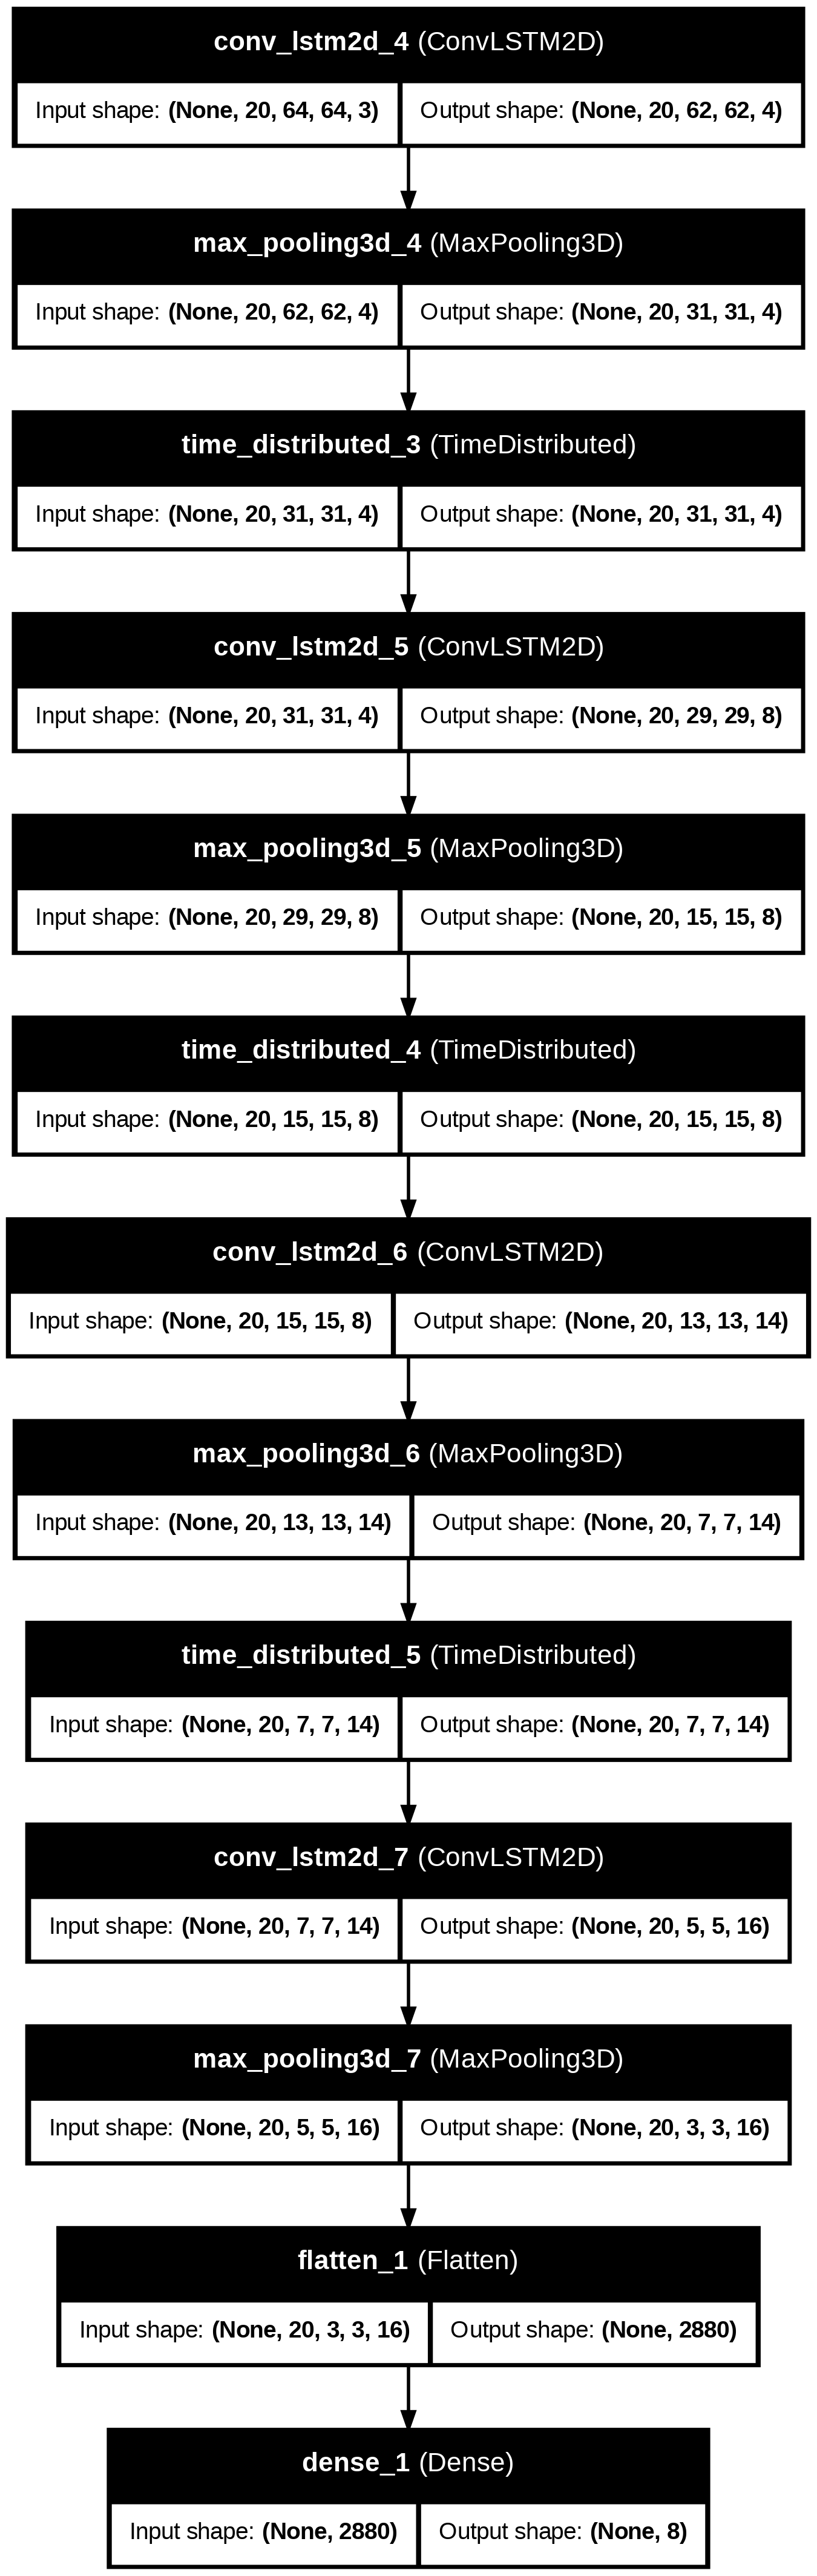

In [25]:
plot_model(convlstm_model,to_file='convlstm_model_structure_plot.png',show_shapes =True,show_layer_names=True)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping_callback =EarlyStopping(monitor='val_loss',patience=10,mode='min',restore_best_weights=True)
convlstm_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
convlstm_model_training_history= convlstm_model.fit(x=features_train,y=labels_train, epochs=50,batch_size=4,shuffle= True, validation_split =0.2,callbacks=[early_stopping_callback])



Epoch 1/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 311s 2s/step - accuracy: 0.1786 - loss: 1.9815 - val_accuracy: 0.4909 - val_loss: 1.3858
Epoch 2/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 308s 2s/step - accuracy: 0.5037 - loss: 1.3415 - val_accuracy: 0.5879 - val_loss: 1.1549
Epoch 3/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 318s 2s/step - accuracy: 0.6395 - loss: 1.0372 - val_accuracy: 0.5273 - val_loss: 1.2273
Epoch 4/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.6777 - loss: 0.8742 - val_accuracy: 0.6909 - val_loss: 0.8527
Epoch 5/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 315s 2s/step - accuracy: 0.7164 - loss: 0.7453 - val_accuracy: 0.7091 - val_loss: 0.8107
Epoch 6/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 330s 2s/step - accuracy: 0.7762 - loss: 0.6432 - val_accuracy: 0.7030 - val_loss: 0.8140
Epoch 7/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 317s 2s/step - accuracy: 0.8070 - loss: 0.5409 - val_accuracy: 0.6970 - val_loss: 0.7877
Epoch 8/50
165/165 ━━━━━━━━━━━━━━━━━━━━ 325s 2s/step - accuracy: 0.8506 - loss: 0.4134 - val_accu

In [30]:
model_evaluation_history =convlstm_model.evaluate(features_test,labels_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 31s 3s/step - accuracy: 0.7936 - loss: 0.9211


In [31]:
model_evaluation_accuracy, model_evaluation_loss =model_evaluation_history
date_time_format='%Y_%m_%d__%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt,date_time_format)
model_file_name=f'convlstm_model___Date_iTme_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)


In [32]:
def plot_metric(model_training_history,metric_name_1,metric_name_2,plot_name):
  metric_value_1= model_training_history.history[metric_name_1]
  metric_value_2= model_training_history.history[metric_name_2]
  epochs=range(len(metric_value_1))
  plt.plot(epochs,metric_value_1,'blue',label=metric_name_1)
  plt.plot(epochs,metric_value_2,'red',label=metric_name_2)
  plt.title(str(plot_name))
  plt.legend()


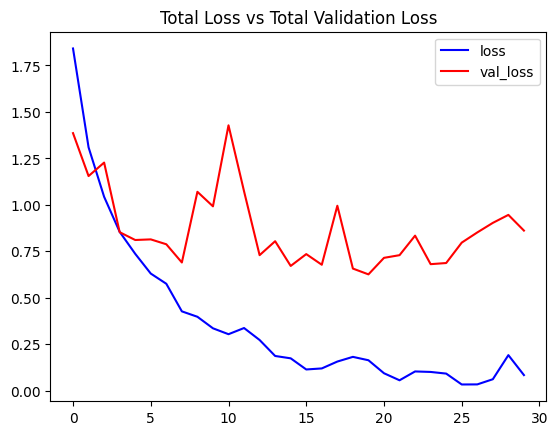

In [33]:
plot_metric(convlstm_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')


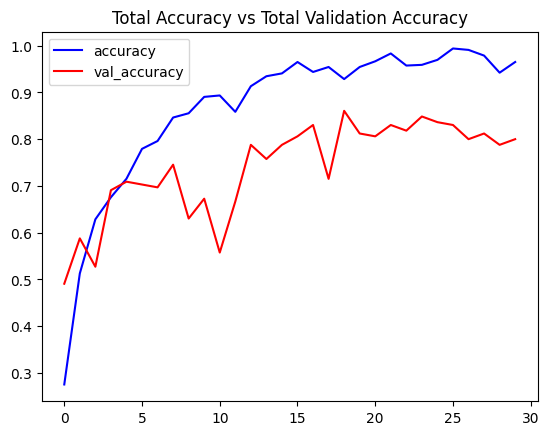

In [34]:
plot_metric(convlstm_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')


LSTM Approach

In [35]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Dropout, Flatten, LSTM, Dense
def create_LRCN_model():
  model=Sequential()
  model.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=(SEQUENCE_LENGTH, IMAGE_HEIGHT, IMAGE_WIDTH, 3)))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(32,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(4,4)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  model.add(TimeDistributed(Dropout(0.25)))

  model.add(TimeDistributed(Conv2D(64,(3,3),padding='same',activation='relu')))
  model.add(TimeDistributed(MaxPooling2D(2,2)))
  #model.add(TimeDistributed(Dropout(0.25)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(32))
  model.add(Dense(len(CLASSES_LIST),activation='softmax'))
  model.summary()
  return model



In [38]:
LRCN_model=create_LRCN_model()
print('Model Created')

  super().__init__(**kwargs)



Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_18                  │ (None, 20, 64, 64, 16)      │             448 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_19                  │ (None, 20, 16, 16, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_20                  │ (None, 20, 16, 16, 16)      │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_21                  │ (None, 20, 16, 16, 32)      │           4,640 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_22                  │ (None, 20, 4, 4, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_23                  │ (None, 20, 4, 4, 32)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_24                  │ (None, 20, 4, 4, 64)        │          18,496 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_25                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_26                  │ (None, 20, 2, 2, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_27                  │ (None, 20, 2, 2, 64)        │          36,928 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_28                  │ (None, 20, 1, 1, 64)        │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_29                  │ (None, 20, 64)              │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 8)                   │             264 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 73,192 (285.91 KB)

 Trainable params: 73,192 (285.91 KB)

 Non-trainable params: 0 (0.00 B)

Model Created


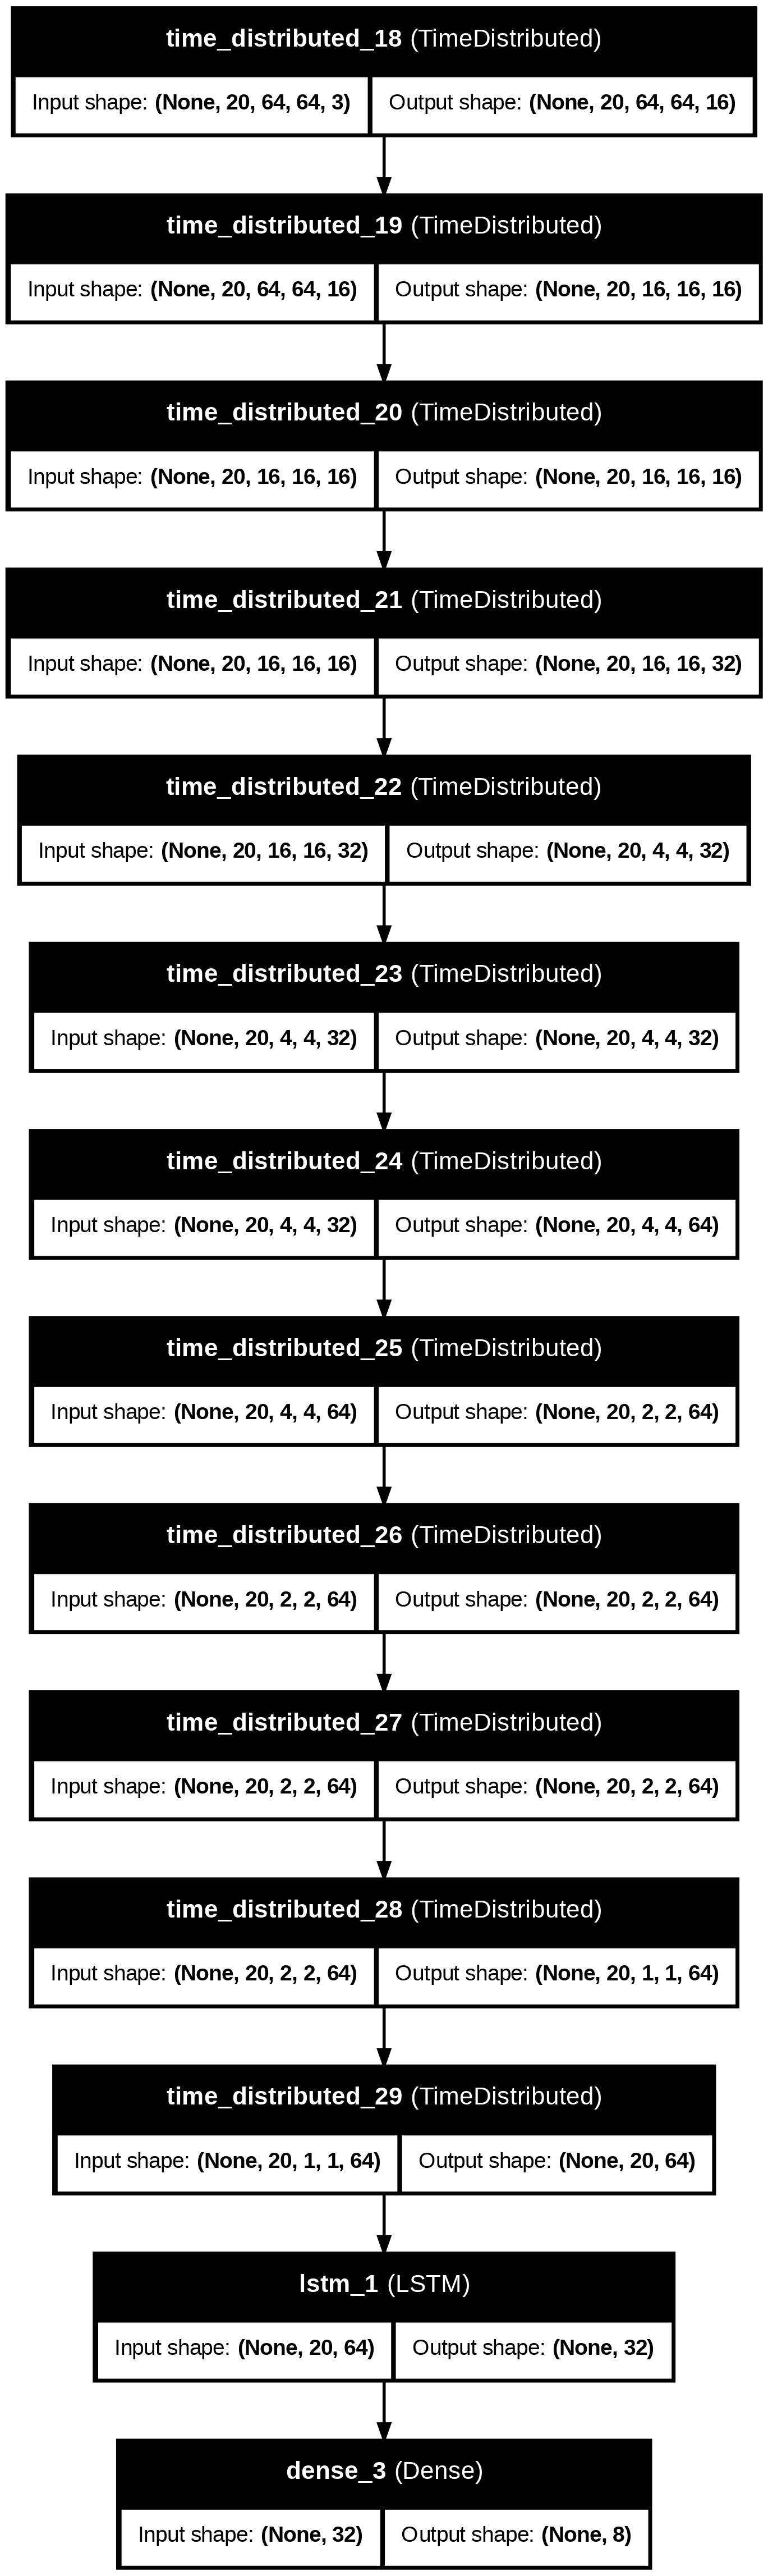

In [39]:
plot_model(LRCN_model,to_file='LCRN_model_structure_plot.png',show_shapes=True,show_layer_names=True)

In [40]:
early_stopping_callback=EarlyStopping(monitor='val_loss',patience=15,mode='min',restore_best_weights=True)
LRCN_model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
LRCN_model_training_history=LRCN_model.fit(x=features_train, y=labels_train,epochs=70,batch_size=4,shuffle=True,validation_split=0.2,callbacks=[early_stopping_callback])


Epoch 1/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 160s 793ms/step - accuracy: 0.1480 - loss: 2.0826 - val_accuracy: 0.2667 - val_loss: 1.9261
Epoch 2/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 106s 643ms/step - accuracy: 0.3027 - loss: 1.7817 - val_accuracy: 0.3030 - val_loss: 1.7959
Epoch 3/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 143s 651ms/step - accuracy: 0.3457 - loss: 1.6573 - val_accuracy: 0.3636 - val_loss: 1.5346
Epoch 4/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 138s 626ms/step - accuracy: 0.4131 - loss: 1.4818 - val_accuracy: 0.5455 - val_loss: 1.2681
Epoch 5/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 138s 602ms/step - accuracy: 0.5226 - loss: 1.3378 - val_accuracy: 0.5030 - val_loss: 1.2865
Epoch 6/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 146s 626ms/step - accuracy: 0.5361 - loss: 1.2002 - val_accuracy: 0.7273 - val_loss: 0.8787
Epoch 7/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 144s 640ms/step - accuracy: 0.6372 - loss: 1.0191 - val_accuracy: 0.7091 - val_loss: 0.9016
Epoch 8/70
165/165 ━━━━━━━━━━━━━━━━━━━━ 140s 629ms/step - accuracy: 0.6540 -

In [41]:
model_evaluation_history=LRCN_model.evaluate(features_test,labels_test)


9/9 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8716 - loss: 0.4205


In [42]:
model_evaluation_accuracy, model_evaluation_loss =model_evaluation_history
date_time_format='%Y_%m_%d__%H_%M_%S'
current_date_time_dt=dt.datetime.now()
current_date_time_string=dt.datetime.strftime(current_date_time_dt,date_time_format)
model_file_name=f'LCRN_model___Date_iTme_{current_date_time_string}__Loss_{model_evaluation_loss}__Accuracy_{model_evaluation_accuracy}.h5'
convlstm_model.save(model_file_name)


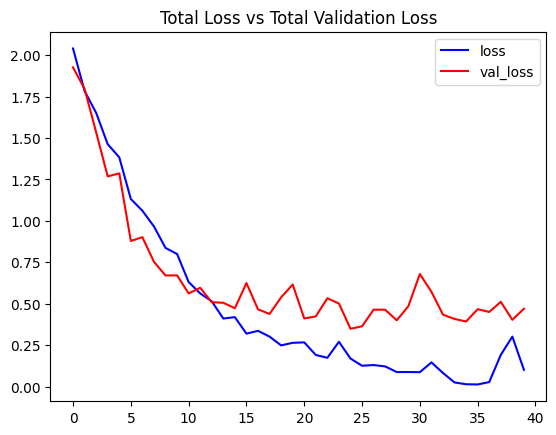

In [43]:
plot_metric(LRCN_model_training_history,'loss','val_loss','Total Loss vs Total Validation Loss')


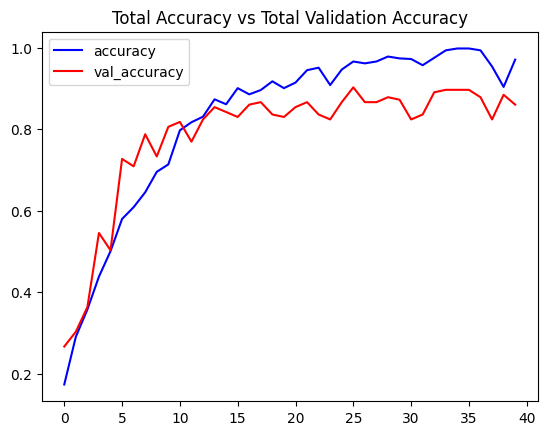

In [44]:
plot_metric(LRCN_model_training_history,'accuracy','val_accuracy','Total Accuracy vs Total Validation Accuracy')


Testing

In [101]:
import os
from yt_dlp import YoutubeDL
import re

def sanitize_filename(filename):
    return re.sub(r'[\\/:"*?<>|]+', '_', filename)
def download_youtube_videos(youtube_video_url, output_directory):
    ydl_opts = {
        'outtmpl': f'{output_directory}/%(title)s.%(ext)s',
        'format': 'best',
        'quiet': True
    }
    with YoutubeDL(ydl_opts) as ydl:
        info = ydl.extract_info(youtube_video_url, download=True)
        sanitized_title = sanitize_filename(info['title'])
        return sanitized_title


In [105]:
test_videos_directory ='test_videos'
os.makedirs(test_videos_directory, exist_ok = True)
video_title = download_youtube_videos('https://www.youtube.com/watch?v=UtWrczpb5oQ', test_videos_directory)
input_video_file_path=f'{test_videos_directory}/{sanitize_filename(video_title)}.mp4'

In [106]:
def predict_on_video(video_file_path, output_file_path, SEQUENCE_LENGTH):
    video_reader = cv2.VideoCapture(video_file_path)

    original_video_width = int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
    original_video_height = int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = int(video_reader.get(cv2.CAP_PROP_FPS))

    video_writer = cv2.VideoWriter(
        output_file_path,
        cv2.VideoWriter_fourcc(*'mp4v'),
        fps,
        (original_video_width, original_video_height)
    )

    # Preprocessing
    frames_queue = deque(maxlen=SEQUENCE_LENGTH)
    predicted_class_name = ''

    while video_reader.isOpened():
        ok, frame = video_reader.read()
        if not ok:
            break

        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))
        normalized_frame = resized_frame / 255.0
        frames_queue.append(normalized_frame)

        if len(frames_queue) == SEQUENCE_LENGTH:
            predicted_labels_probabilities = LRCN_model.predict(np.expand_dims(frames_queue, axis=0))[0]
            predicted_label = np.argmax(predicted_labels_probabilities)
            predicted_class_name = CLASSES_LIST[predicted_label]

        cv2.putText(
            frame,
            predicted_class_name,
            (10, 20),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,
            (0, 255, 0),
            2
        )

        # Write frame to video writer
        video_writer.write(frame)

    video_reader.release()
    video_writer.release()

In [107]:
output_video_file_path=f'{test_videos_directory}/{sanitize_filename(video_title)}.mp4'
predict_on_video(input_video_file_path,output_video_file_path, SEQUENCE_LENGTH)
VideoFileClip(output_video_file_path,audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [109]:
def predict_single_action(video_file_path,SEQUENCE_LENTH):
  video_reader=cv2.VideoCapture(video_file_path)
  original_video_width=int(video_reader.get(cv2.CAP_PROP_FRAME_WIDTH))
  original_video_height= int(video_reader.get(cv2.CAP_PROP_FRAME_HEIGHT))
  frames_list=[]
  predicted_class_name =''
  video_frames_count=int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))
  skip_frames_window= max(int(video_frames_count/SEQUENCE_LENGTH),1)
  for frame_counter in range(SEQUENCE_LENGTH):
    video_reader.set(cv2.CAP_PROP_POS_FRAMES,frame_counter* skip_frames_window)
    success, frame = video_reader.read()
    if not success:
      break
    resized_frame=cv2.resize(frame,(IMAGE_HEIGHT,IMAGE_WIDTH))
    normalized_frame=resized_frame / 255
    frames_list.append(normalized_frame)
  predicted_labels_probabilities=LRCN_model.predict(np.expand_dims(frames_list,axis=0))[0]
  predicted_label= np.argmax(predicted_labels_probabilities)
  predicted_class_name=CLASSES_LIST[predicted_label]
  print(f'Action Predicted:{predicted_class_name}\n Confidence:{predicted_labels_probabilities[predicted_label]}')
  video_reader.release()


In [110]:
video_title=download_youtube_videos('https://www.youtube.com/watch?v=y1qEfLhpdMI',test_videos_directory)
input_video_file_path=f'{test_videos_directory}/{video_title}.mp4'
predict_single_action(input_video_file_path,SEQUENCE_LENGTH)
VideoFileClip(input_video_file_path, audio=False, target_resolution=(300,None)).ipython_display()

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
Action Predicted:HorseRace
 Confidence:0.9955253005027771
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4
